# Detecting spam mail
This notebook demonstrates the usage of a word2vec and convolutional neural network to detect email spam

In [1]:
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D, GlobalMaxPool1D, Embedding, Activation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import PorterStemmer
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from IPython.display import Image

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to /home/nrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Convolutional layers
C-layers are the feature extractor (Substitute to feature engineerin) used mostly in images. However, they have proven exceptionally usefull in natural languange processing as well

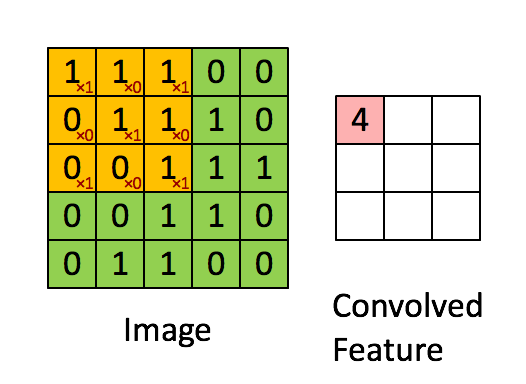

In [2]:
Image('../SpamDetection/1_GcI7G-JLAQiEoCON7xFbhg.gif')

## Fully connected layer
The fully connected layer is created by flattening the last c-layer. This ultimately corresponds to independent features which are the most common method to provide input into a neural network

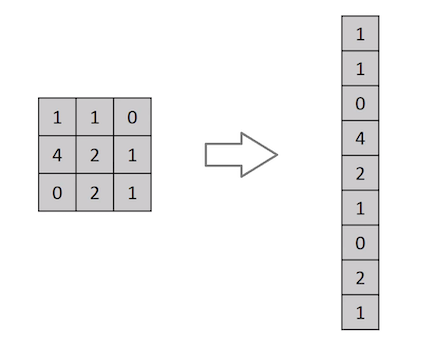

In [3]:
Image('../SpamDetection/1_GLQjM9k0gZ14nYF0XmkRWQ.png')

In [4]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    stops = stopwords.words('english')
    #print(stops)
    porter = PorterStemmer()
    for word in sentence.split():
        if word in stops:
            sentence = sentence.replace(word, '')
        sentence = sentence.replace(word, porter.stem(word))
    return sentence.lower()

## Project

### Load and display the data

In [5]:
df = pd.read_csv('../SpamDetection/SPAM_text_message_20170820_Data.csv')
df['Message'] = df['Message'].apply(preprocess_text)
df.head()

,Category,Message
0,ham,go jurong pot crazi avail bugi great world ...
1,ham,ok lar joke wif oni
2,spam,free entri wkli comp w fa cup fal tkt t may ...
3,ham,u dun say earli hor c alreadi say
4,ham,nah think goe usf live around re though


### Split the text into words

In [6]:
mes = []
for i in df['Message']:
    mes.append(i.split())
print(mes[:2])

[['go', 'jurong', 'pot', 'crazi', 'avail', 'bugi', 'great', 'world', 'la', 'buffet', 'ce', 'got', 'amor', 'wat'], ['ok', 'lar', 'joke', 'wif', 'oni']]


### (1) Create a word2vec model - Coding assignment
A word2vec model maps each word to a vector with a unique integer. 
1. Call the model class for the word2vec model
2. Choose the number of high frequency words you want to use

In [7]:
word2vec_model = Word2Vec(mes, size=500, window=3, min_count=1, workers=16)
print(word2vec_model)

Word2Vec(vocab=7229, size=500, alpha=0.025)


### (2) Coding a Transform the input data to comply with the model specifications
Map the vectors into sequences by choosing a number of words allowed in each sequence

In [8]:
token = Tokenizer(7229)
token.fit_on_texts(df['Message'])
text = token.texts_to_sequences(df['Message'])
text = pad_sequences(text, 75) 
print(text[:1])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    4 3635 2043  655  593 1162   78  335  897
  2559 1700   15 3636   79]]


### Create a binary array for the y label

In [9]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Category'])
y = to_categorical(y)
y[:1]

array([[1., 0.]], dtype=float32)

### (3) Split the data set into three sets
choose the validation set size that will make the test and validation set equal in size

In [10]:
x_train, x_test, y_train, y_test = train_test_split(np.array(text), y, test_size=0.2, random_state=123, stratify=y)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=123, stratify=y_train)

### (4) Build the model using Keras sequential mode
1. Choose the number of nodes in the convolutional layer
2. Choose the dropout rate for each layer
3. Optional - Add more layers to add more complexity

In [11]:
keras_model = Sequential()
keras_model.add(word2vec_model.wv.get_keras_embedding(True))
keras_model.add(Dropout(0.2))

keras_model.add(Conv1D(50, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))

keras_model.add(Conv1D(100, 3, activation='relu', padding='same', strides=1))
keras_model.add(MaxPool1D())
keras_model.add(Dropout(0.2))

keras_model.add(Conv1D(200, 3, activation='relu', padding='same', strides=1))
keras_model.add(GlobalMaxPool1D())
keras_model.add(Dropout(0.2))

keras_model.add(Dense(200))
keras_model.add(Activation('relu'))
keras_model.add(Dropout(0.2))

keras_model.add(Dense(2))
keras_model.add(Activation('softmax'))
keras_model.compile(loss='binary_crossentropy', metrics=['acc'], optimizer='adam')
keras_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 500)         3614500   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 500)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 50)          75050     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 50)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 50)          0         
_________________________________________________________________
conv1d_2 (Conv1D)    

### Train the model

In [12]:
keras_model.fit(x_train, y_train, batch_size=16, epochs=3, validation_data=(x_val, y_val))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 3342 samples, validate on 1115 samples
Epoch 1/3
3342/3342 [==============================] - 15s 4ms/step - loss: 0.4140 - acc: 0.8656 - val_loss: 0.3720 - val_acc: 0.8655
Epoch 2/3
3342/3342 [==============================] - 14s 4ms/step - loss: 0.1766 - acc: 0.9375 - val_loss: 0.0661 - val_acc: 0.9812
Epoch 3/3
3342/3342 [==============================] - 15s 4ms/step - loss: 0.0399 - acc: 0.9883 - val_loss: 0.0727 - val_acc: 0.9812


### (5) Predict performance for the train and test set
Choose the probabilty threshold for classifying something as spam

In [13]:
prob_threshold = 0.5

y_pred_train = keras_model.predict(x_train)
y_pred_test = keras_model.predict(x_test)
y_pred_train = (y_pred_train >= prob_threshold)
y_pred_test = (y_pred_test >= prob_threshold)

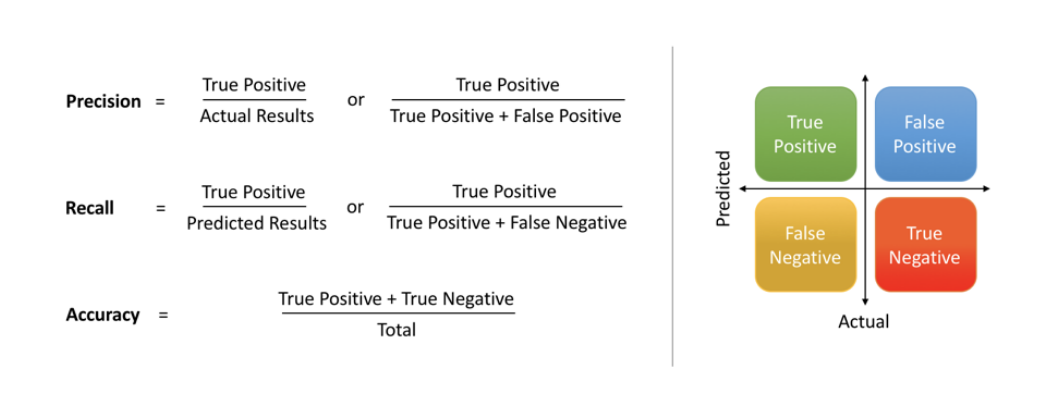

In [14]:
Image("../SpamDetection/metrics.png")

In [15]:
def metrics(y, y_pred, testOrTrain=None):
    
    cm = confusion_matrix(y_true=y, y_pred=y_pred)
    accuracy = (np.sum(np.diagonal(cm)) / cm.sum())
    
    precision = cm[0, 0] / (cm[0, 0] + cm[0, -1])
    recall =  cm[0, 0] / (cm[0, 0] + cm[-1, 0])
    f2 = (1+2**2)*((precision*recall) / ((2**2)*precision + recall ))
    
    if testOrTrain is not None:
        print('%s set' %(testOrTrain))
        print('\n')
        print('Accuracy from cm: %.3f' % (accuracy))
        print('Precision: %.3f' % (precision))
        print('Recall: %.3f' % (recall))
        print('F2: %.3f' % (f2))
        print('\n')

    
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Train set


Accuracy from cm: 0.999
Precision: 1.000
Recall: 0.998
F2: 0.999




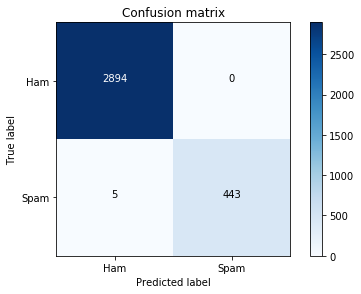

In [16]:
metrics(y_train[:, 1], y_pred_train[:, 1], testOrTrain='Train')
cm = confusion_matrix(y_train[:, 1], y_pred_train[:, 1])
plot_confusion_matrix(cm, classes=['Ham','Spam'], title='Confusion matrix')

Test set


Accuracy from cm: 0.986
Precision: 0.996
Recall: 0.988
F2: 0.989




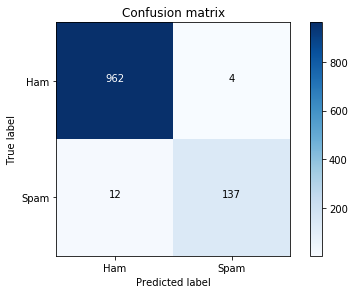

In [17]:
metrics(y_test[:, 1], y_pred_test[:, 1], testOrTrain='Test')
cm = confusion_matrix(y_test[:, 1], y_pred_test[:, 1])
plot_confusion_matrix(cm, classes=['Ham','Spam'], title='Confusion matrix')